# Chapter 5: Shortest path algorithms


*Selected Topics in Mathematical Optimization*

*2016-2017*

**Bernard De Baets**

**Michiel Stock**

**Raúl Pérez-Fernández**

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Representing graphs in Python

Graphs are discrete mathematical objects, represented as a tuple $G=(V, E)$ with $V$ the set of vertices (nodes, points) and $E$ the set of edges (links, arcs, lines) that connect the vertices.

Consider for example the graph below.

![A directed unweighted graph](Figures/unweighted_graph.png)

This graph contains five edges: A, B, C, D and E and nine vertices. Since each of the vertices has a direction from one node to another so we call this a **directed graph**.

Like most programming languages, Python does not provide direct support for graphs a data types. Graphs can however be represented by [**dictionaries**](https://docs.python.org/2/tutorial/datastructures.html#dictionaries). Dictionaries in Python store key-value pairs in a way such that accessing, insertion and deletion of new elements can be done very efficiently. The keys will represent the edges, while its associated values is the set of vertices to which depart from this node.

For example, the unweighted graph above is represented bij the following code.

In [4]:
unweighted_graph = {'A' : set(['B']),
                   'B' : set(['C']),
                   'C' : set(['A', 'B', 'E']),
                   'D' : set(['A']),
                   'E' : set(['D', 'D'])  # set data structure only contains unique elements
                   }                     # only one node will be retained

Note that we store the outgoing vertices in a [**set**](https://docs.python.org/2/tutorial/datastructures.html#sets) data structure. This will allow us to perform certain operations faster. Note that of the two vertices starting for E only one is retained. 

In [5]:
unweighted_graph['E']

{'D'}

In this chapter, we will focus on algorithms that process **weighted graphs**, i.e. graphs on which the vertices have a weight. For example:
![A weighted directed graph](Figures/weighted_graph.png)
We will store each vertex now as a tuple containing the weight and the edge it is connected to. For this example:

In [6]:
weighted_graph = {'A' : set([(3, 'B')]),
                   'B' : set([(2, 'C')]),
                   'C' : set([(6, 'A'), (1, 'B'), (0.3, 'E')]),
                   'D' : set([(9, 'A')]),
                   'E' : set([(2.8, 'D'), (4.1, 'D'), (4.2, 'E')])  # two paths from E -> D
                    }

Storing a weighted vertex as `(weight, outgoing node)` has the advantage that the native `sort()` function in Python can be used to order vertices by weight, something which will be useful in the algorithms we will implement.

## Priority queues using heapq

In order to efficiently implement the algorithms from this chapter, we will need to make use of a **priority queue**. A priority queue is a data structure which is perhaps most easily explained using a small example.

A professor receives an enormous number of e-mails during the day. Because he cannot respond to them all into detail, the professor witholds only the 50 most important mails and processes them in the evening. Consider the following algorithm the prof might use to mananage his set of important mails during the day.

In [7]:
from random import random

# simulate 10000 e-mails
# each e-mail is represented by an 'importance' and 
# an indice (the number of the mail)
emails = [(random(), i) for i in range(10000)]

# first five mails
emails[:5]

[(0.13081966170392334, 0),
 (0.6298479625350302, 1),
 (0.876648366759332, 2),
 (0.5523879796371531, 3),
 (0.7225573981492348, 4)]

In [8]:
# retain the 50 most important mails using sort

def top_k_sorted(k=50):
    top_set = [(-1e10, -1) for i in range(k)]  # initialize the to respond list
    for importance, id in emails:
        # assume that the least important mail is on position 0
        if top_set[0][0] < importance:
            top_set[0] = (importance, id)  # replace least important mail
            top_set.sort()  # sort
    return top_set

top_k_sorted()

[(0.9957204940853647, 7998),
 (0.995938541147811, 7799),
 (0.9960281504253524, 8846),
 (0.9960349591327331, 5669),
 (0.9963106691491348, 7138),
 (0.9963526840341338, 8023),
 (0.996414129916703, 850),
 (0.996495725683636, 2807),
 (0.9965097560914448, 1590),
 (0.996643893597195, 501),
 (0.9966718349581818, 6946),
 (0.9966791706653644, 3024),
 (0.9967348657461875, 7209),
 (0.9967499713387636, 7884),
 (0.996778012865606, 2882),
 (0.9968452174922564, 9393),
 (0.9970919768410577, 2267),
 (0.9971737387874643, 6212),
 (0.9972171915117318, 2591),
 (0.9972640946498932, 1654),
 (0.9974060920347568, 6701),
 (0.9974544889435011, 5073),
 (0.9974953212297973, 8499),
 (0.9976878149645392, 5497),
 (0.9977472279405859, 7419),
 (0.9979273866474182, 8501),
 (0.9979302855202323, 9767),
 (0.9979307186761142, 3283),
 (0.9980754782364336, 4353),
 (0.9981667914200366, 5249),
 (0.9982131473694276, 235),
 (0.9984405460215129, 8638),
 (0.9984877819000114, 7716),
 (0.9985795720207498, 2105),
 (0.9987816357045822, 

Taking a closer look, this routine is very wasteful of the time of the poor professor! Each time he updates his list of to-respond mails, he has to completely sort it so that he can easily access his least important mail. Sorting a list has a time complexity of $\mathcal{O}(n\log(n))$ for a list of $n$ elements. Sorting the complete list is overkill, as the professor wants the most important mails of the list.

A more clever data structure for these types of tasks is a [**heap**](https://docs.python.org/2/library/heapq.html). A heap is a partially sorted list such that `heap[k] <= heap[2*k+1]` and `heap[k] <= heap[2*k+2]` for all `k`.

A heap is based on the idea of a tournament, as represented below (number represent indices, not values). 

```
                               0

              1                                 2

      3               4                5               6

  7       8       9       10      11      12      13      14

15 16   17 18   19 20   21 22   23 24   25 26   27 28   29 30
```
A list `a` that satisfies the heap property always has that `a[0] < a[1]` and `a[0] < a[2]`, while `a[1] < a[3]` and `a[1] < a[4]` etc.

The following operations can be done using a heap:
- `heappush`: adding an item to the heap while maintaining the heap property ($\mathcal{O}(\log(n))$)
- `heapop`: removing the item with the lowest value while maintaining the heap property ($\mathcal{O}(\log(n))$)
- `heappushpop`: replacing the item with the lowest value by another item while maintaining the heap property ($\mathcal{O}(\log(n))$)
- peeking: looking the item at position 0, which has the lowest value ($\mathcal{O}(1)$)

Heaps are implemented in `heapq` in Python. Consider our example.

In [9]:
from heapq import heappop, heappush, heappushpop

def top_k_heaped(k=50):
    top_set = [(-1e10, -1) for i in range(k)]  # initialize the to respond list
    for importance, id in emails:
        # assume that the least important mail is on position 0
        if top_set[0][0] < importance:
            # replace least important mail while maintaining the heap property
            heappushpop(top_set, (importance, id))  
    return top_set

top_k_heaped()

[(0.9957204940853647, 7998),
 (0.9960281504253524, 8846),
 (0.995938541147811, 7799),
 (0.996495725683636, 2807),
 (0.9963106691491348, 7138),
 (0.9960349591327331, 5669),
 (0.996414129916703, 850),
 (0.996643893597195, 501),
 (0.9967348657461875, 7209),
 (0.9963526840341338, 8023),
 (0.996778012865606, 2882),
 (0.9968452174922564, 9393),
 (0.9987816357045822, 8249),
 (0.9965097560914448, 1590),
 (0.9966791706653644, 3024),
 (0.9971737387874643, 6212),
 (0.9972171915117318, 2591),
 (0.9974060920347568, 6701),
 (0.9977472279405859, 7419),
 (0.9966718349581818, 6946),
 (0.9967499713387636, 7884),
 (0.9970919768410577, 2267),
 (0.9972640946498932, 1654),
 (0.9974953212297973, 8499),
 (0.9984405460215129, 8638),
 (0.998806302877272, 8419),
 (0.9998501128212993, 8214),
 (0.9988097646788272, 1053),
 (0.9992436536801635, 7282),
 (0.9998578829247136, 1184),
 (0.9998617154924323, 6688),
 (0.9979302855202323, 9767),
 (0.9979307186761142, 3283),
 (0.9982131473694276, 235),
 (0.9995564114761746, 8

Both algorithms return the same list of e-mails, though using a heap to implement a priority queue is more efficient in resources.

In [10]:
%timeit top_k_sorted()

100 loops, best of 3: 4.12 ms per loop


In [11]:
%timeit top_k_heaped()

1000 loops, best of 3: 1.27 ms per loop


In [12]:
#sort = nlog(n)
#heap = log(n)

## Dijkstra's shortest path algorithm

Dijkstra's algorithm is a popular algorithm to find the shortest path between the nodes of a graph. The algorithm can be used in two ways:

- when both a source and a sink node are provided, the algorithm gives the list of nodes of the shortest path, together with the length (distance of the path).
- when only a source is given, the shortest distance between the source and all (accessable) nodes is returned together with a dictionary representing the tree of the shortest paths between the source and other nodes.

The pseudocode can be found below.

### Pseudocode of Dijkstra's shortest path algorithm
Source: Wikipedia.org
```
1  function Dijkstra(Graph, source, sink (optional)):
2      distance[source] := 0  // initialize a dictionary with distance
3                             // to source
4      for each vertex V in Graph: 
5          if V ≠ source
6              distance[V] := infinity
7      previous := empty dict   // stores the previous node in path
8
10     make empty priority queue Q for vertices to check
11     Q.add_with_priority(source, 0)  # first check the source
12
13
14     while Q is not empty:                     // The main loop
15         get node U with smallest distance from Q
16         if U is the sink (if provided) 
17              break the loop
17         for every neighbor V of U:
18             alternative := distance[U] + dist(U, V)
18             if alternative < distance[V]
19                 distance[V] := alternative
20                 previous[V] := U
21                 Q.add_with_priority(V, alternative)
22
23     if sink is given
24         reconstruct shortest path
25         return shortest path and length of path
26     else
27         return distance, previous
```

In [13]:
from numpy import inf
def dijkstra(graph, source, sink=None):
    distance = {v: inf for v in graph}
    distance[source] = 0
    previous = dict()
    Q = list()    
    heappush(Q, (source, 0))
    
    while len(Q)!=0:
        (u, _) = heappop(Q)
        if u == sink:
            break
        for w, v in graph[u]:
            alternative = distance[u] + w
            if alternative < distance[v]:
                distance[v]=alternative
                previous[v]=u
                heappush(Q, (v, alternative))
    
    if sink is None:
        return distance, previous
    else:
        return reconstruct_path(previous, source, sink), distance[sink]

### Pseudocode of path reconstruction  algorithm
```
1 function reconstruct_path(previous, source, sink)
2    if the source is not in previous
3          return empty path
4    V := sink   \\ path is reconstructed backwards
5    path := [V]  \\ path is a list of nodes
6    while V is not source
7         V := previous node in path
8         add V in beginning of the path
9    return the path
```

In [14]:
def reconstruct_path(previous, source, sink):
    if sink not in previous:
        return []
    
    v = sink
    path = [v]
    while v != source:
        v = previous[v]
        path.append(v)
    return list(reversed(path))

**Assignment 1: Dijkstra**

1. Complete the implementation for Dijstra's algorithm and the path reconstruction function
2. Find the shortest path from node A to I in the example graph below. Calculate the shortest distance from A to any other node. Compare both running times with `%timeit`.

![Example network](Figures/example_graph.png)

In [15]:
# the above graph as an adjacency list
graph = {'A' : set([(2, 'B'), (3, 'D')]),
        'B' : set([(1, 'C'), (5, 'E')]),
        'C' : set([(2, 'D'), (1, 'E')]),
        'D' : set([(3, 'E')]),
        'E' : set([(2, 'B'), (3, 'F')]),
        'F' : set([(5, 'G'), (8, 'I')]),
        'G' : set([(2, 'H'), (5, 'I')]),
        'H' : set([(3, 'I')]),
        'I' : []}

In [16]:
dijkstra(graph, 'A', 'I')

(['A', 'B', 'C', 'E', 'F', 'I'], 15)

In [17]:
dijkstra(graph, 'A')

({'A': 0, 'B': 2, 'C': 3, 'D': 3, 'E': 4, 'F': 7, 'G': 12, 'H': 14, 'I': 15},
 {'B': 'A',
  'C': 'B',
  'D': 'A',
  'E': 'C',
  'F': 'E',
  'G': 'F',
  'H': 'G',
  'I': 'F'})

In [18]:
%timeit dijkstra(graph, 'A', 'I')

100000 loops, best of 3: 13.9 µs per loop


In [19]:
%timeit dijkstra(graph, 'A')

100000 loops, best of 3: 12.3 µs per loop


## A* shortest path algorithm

It is hard to explain the algorithm into more depth than [here](http://theory.stanford.edu/~amitp/GameProgramming/) and [here](http://www.redblobgames.com/pathfinding/a-star/introduction.html).

Dijkstra's algorithm is guaranteed to find a shortest path on any (positively weighted) graph. But because no assumptions are made of the nature of the graph, Dijkstra's algorithm cannot exploit prior knowledge to speed up its search. Consider the problem of finding a shortest path on a grid using Dijkstra.

![Dijkstra's algorithm for grid with no obstacles.](Figures/Dijkstra.png)

In the figure above, it is clear that Dijkstra searches very inefficient: it tries to expand its seach horizon around the starting point in order to find the shortest path. Consider a 'greedy' algorithm which always tries to move as close to the goal as possible.

![Greedy search for grid with no obstacles.](Figures/best-first-search.png)

Much better! The algorithm always moves in the right direction. What happens when a direct path between the starting position and the goal is not possible?

![Dijkstra's algorithm for grid with an obstacle.](Figures/dijkstra-trap.png)

Dijkstra is guaranteed to find the optimal path, but again only after much exploring! Let us see of the greedy algorithm again fares better.

![Greedy search for grid with an obstacle.](Figures/best-first-search-trap.png)

We see again that the greedy algorithm does much less searching, but this time the path that is returned is not the shortest!

The A\* algorithm lets us have the best of both worlds: it is exact (like Dijkstra's algorithm), but it can also use a **heuristic** to speed up the search. In each iteration, the next neighbor $n$ of the current node that the algorithm considers is chosen based on the heuristic

$$
f(n) = g(n) + h(n)
$$

with $g(n)$ the cost of the path so far and $h(n)$ a heuristic that estimates the cost of the cost of the shortest path from $n$ to the goal. The heuristic $h(n)$ should satify two properties:
1. To guaranty that a shortest path is found, the heuristic should be **admissible**, i.e. it should never overestimate the true distance to goal.
2. Evaluating the heuristic should be cheap (it is either pre-computed or is a function).

So the A\* algorithm is basically the same as Dijkstra's algorithm, but with the main difference that the the latter chooses nodes to explore based on the distance from the starting node, while the latter chooses nodes **based on an estimate of distance to the goal**.

When using A\* to find the shortest path between two physical locations, each node corresponds to a point in space. A good heuristic is the (Euclidian) distance between the nodes, as this will always be a lower bound for the actual distance to travel to the goal.

Consider the following example of finding the path from node $a$ to node $h$.

![Example how A\* uses the heuristics](Figures/astarexample.png)

The shortest path so far is $[a, e]$ and the algorithm needs to choose to explore node $d$ or node $g$. Since the path of $ed$ is shorter than the path $eg$, Dijkstra will choose this node, even though it is farther removed from the goal $h$ (Dijkstra chooses a neighbor $n$ only based on the current path length form the starting node $g(n)$. The A\* algorithm will chose node $g$ to explore, because the estimated path length $f(e) = g(e) + h(e) > f(d)$ and hence will approach the goal. 

#### Representation of the graphs for physical locations

For the assignments above, we will work with graphs representing paths on a two-dimensional plane. 

Each node or location is a point on this plane, e.g. $(x_i, y_i)$. An edge or link between two locations is a tuple of two points: $((x_i, y_i),(x_j, y_j))$. In the link representation, the network is represented as just a list of these links. For example:

In [20]:
from parcour_tools import add_path, load_links, plot_parcour, links_to_graph

links_example = [((1, 1), (1, 3)), ((1, 1), (2, 2)), ((1,3), (2, 2)),
                ((2, 2), (3, 1)), ((2, 2), (3, 3)), ((3, 1), (3, 3))]

Using the function ```links_to_graph``` we can change these links in the more familiar dictionary-based representation.

In [21]:
graph_example = links_to_graph(links_example)
print(graph_example)

{(1, 1): [(1, (1, 3)), (1, (2, 2))], (1, 3): [(1, (1, 1)), (1, (2, 2))], (2, 2): [(1, (1, 1)), (1, (1, 3)), (1, (3, 1)), (1, (3, 3))], (3, 1): [(1, (2, 2)), (1, (3, 3))], (3, 3): [(1, (2, 2)), (1, (3, 1))]}


Which can be visualized using ```plot_parcour``` and we can use the function ```add_path``` to draw a path.

/Users/Louise/Documents/SelectedTopicsOptimization-master/Chapters/05.ShortestPaths/parcour_tools.py:43: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('black')


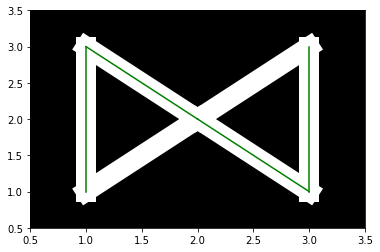

In [22]:
fig, ax = plt.subplots()
plot_parcour(links_example, ax, line_width=20)  # uses the links representation as an input!
ax.set_ylim([0.5, 3.5])
ax.set_xlim([0.5, 3.5])

path_example = [(1, 1), (1, 3), (2, 2), (3, 1), (3, 3)]
add_path(path_example, ax, color='green')

**Assignment 2: A\***

1. Complete the implementation for the A\* algorithm.
2. Some parcours and mazes are given. Use A\* and Dijkstra to find the shortest paths between the lower left corner to the upper right corner. Use the function ```add_path``` to add the path to the figure.
3. Compare running time of the two shortest path algorithms using ```%timeit```.

### Pseudocode of A\* shortest path algorithm
Source from Wikipedia (modified)
```
1  function Astar(Graph, source, sink, heuristic):
2      make empty priority queue Q for vertices to check
3      
4      add source to Q with priority f(source)
5          // use the estimated path length for priority
6              
7      distance[V] := 0   // initialize a dictionary with distance
8                           // to source
9      previous := empty dict   // stores the previous node in path
10
11     while Q is not empty:                     // The main loop
12         pop node U with lowest estimated path length to sink
13         if U is the sink
14              break the loop
15         for every neighbor V of U:
16             distance_source_U := distance[U] + dist(U, V)
17             if V not in distance or distance_source_U < distance[V]
18                 distance[V] := distance_source_U
19                 previous[V] := U
20                 heuristic_V_sink := distance[V] + g(V)
21                 Q.add_with_priority(V, heuristic_V_sink)
22
23     reconstruct shortest path
24     return shortest path and length of path
```

In [23]:
# functions for computing distances
manhattan_distance = lambda x, y : sum([abs(xi - yi) for xi, yi in zip(x, y)])
euclidian_distance = lambda x, y : sum([(xi - yi)**2 for xi, yi in zip(x, y)])**0.5

In [49]:
def a_star(graph, source, sink, heuristic):
    Q = list()
    heappush(Q, (source, heuristic(source, sink)))
    #heappush(Q, (heuristic(source, sink), source))
    distance = {v:inf for v in graph}
    distance[source] = 0
    previous = dict()
    while len(Q) != 0:
        (u, _) = heappop(Q)
        if u == sink:
            break
        for w, v in graph[u]:
            dist_source_u = distance[u] + w
            if v not in distance or dist_source_u < distance[v]:
                distance[v] = dist_source_u
                previous[v] = u
                heuristic_v_sink = distance[v] + heuristic(v, sink)
                heappush(Q, (v, heuristic_v_sink))
    return reconstruct_path(previous, source, sink), distance[sink]

/Users/Louise/Documents/SelectedTopicsOptimization-master/Chapters/05.ShortestPaths/parcour_tools.py:43: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('black')


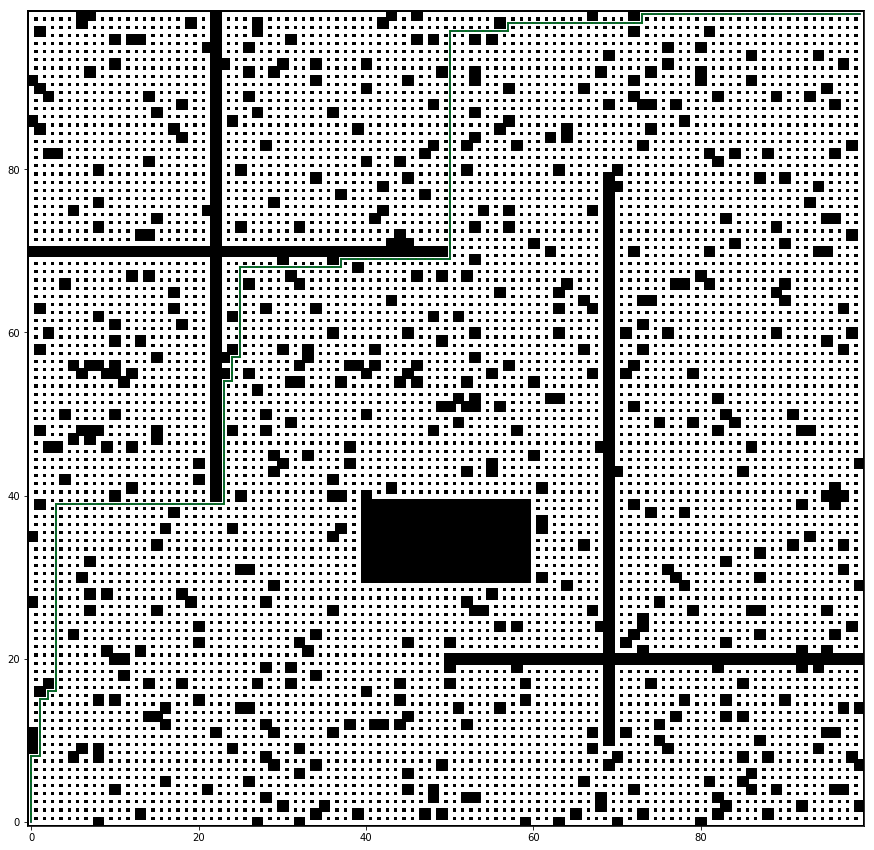

In [ ]:
# a parcour, white lines are the routes that can be followed
# find the shortest path from (0, 0) to (99, 99)
parcour = load_links('Data/large_parcour.csv')

fig, ax = plt.subplots(figsize=(15, 15))

plot_parcour(parcour, ax)
parcour_graph = links_to_graph(parcour)

path_dijkstra, length_dijstra = dijkstra(parcour_graph, (0, 0), (99, 99))
add_path(path_dijkstra, ax, 'red')

path_astar, length_astar = a_star(parcour_graph, (0, 0), (99, 99), manhattan_distance)
add_path(path_astar, ax, 'blue')

path_astar, length_astar = a_star(parcour_graph, (0, 0), (99, 99), euclidian_distance)
add_path(path_astar, ax, 'green')

In [26]:
%timeit path_dijkstra, length_dijstra = dijkstra(parcour_graph, (0, 0), (99, 99))

10 loops, best of 3: 53.5 ms per loop


In [27]:
%timeit path_astar, length_astar = a_star(parcour_graph, (0, 0), (99, 99), manhattan_distance)

10 loops, best of 3: 69.9 ms per loop


/Users/Louise/Documents/SelectedTopicsOptimization-master/Chapters/05.ShortestPaths/parcour_tools.py:43: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('black')


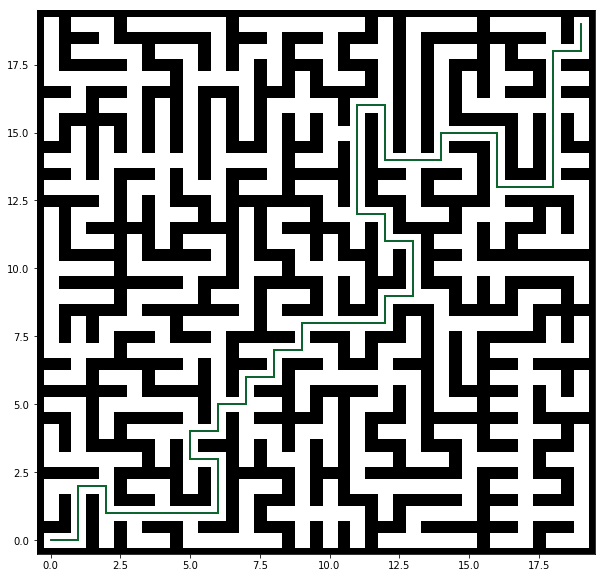

In [28]:
# a small maze, white lines are the routes that can be followed
# find the shortest path from (0, 0) to (99, 99)
small_maze = load_links('Data/small_maze.csv')

fig, ax = plt.subplots(figsize=(10, 10))

plot_parcour(small_maze, ax, line_width=15)
maze_graph = links_to_graph(small_maze)

path_dijkstra, length_dijstra = dijkstra(maze_graph, (0, 0), (19, 19))
add_path(path_dijkstra, ax, 'red')

path_astar, length_astar = a_star(maze_graph, (0, 0), (19, 19), manhattan_distance)
add_path(path_astar, ax, 'blue')

path_astar, length_astar = a_star(maze_graph, (0, 0), (19, 19), euclidian_distance)
add_path(path_astar, ax, 'green')

In [29]:
%timeit path_dijkstra, length_dijstra = dijkstra(maze_graph, (0, 0), (19, 19))

1000 loops, best of 3: 765 µs per loop


In [30]:
%timeit path_astar, length_astar = a_star(maze_graph, (0, 0), (19, 19), manhattan_distance)

1000 loops, best of 3: 1.41 ms per loop


/Users/Louise/Documents/SelectedTopicsOptimization-master/Chapters/05.ShortestPaths/parcour_tools.py:43: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('black')


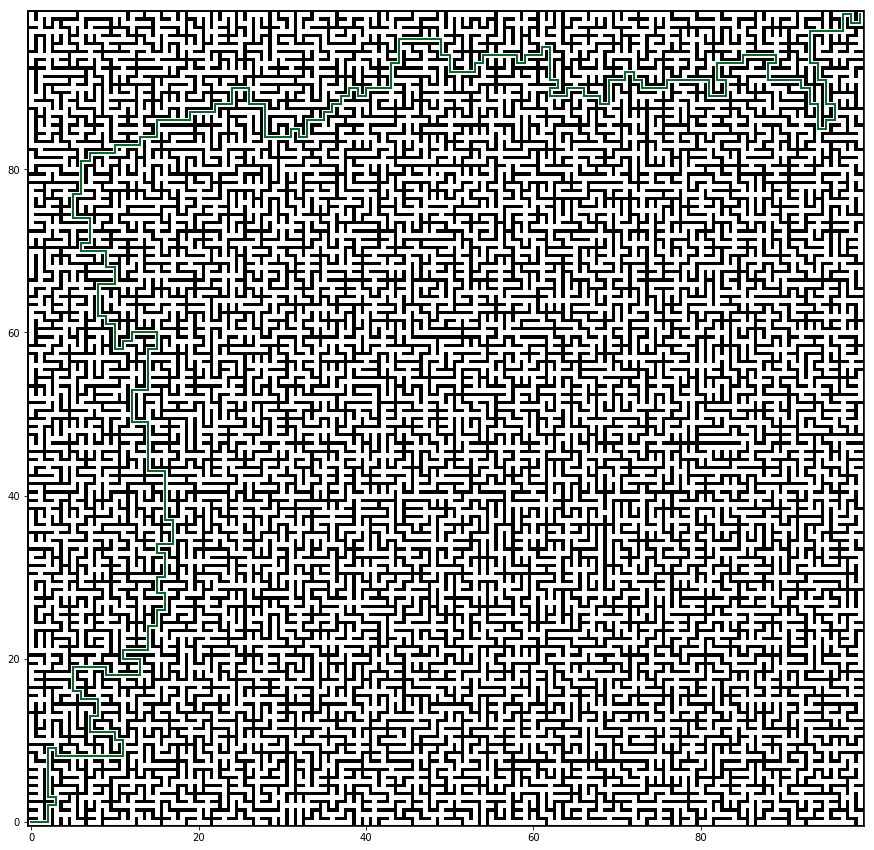

In [31]:
# a small maze, white lines are the routes that can be followed
# find the shortest path from (0, 0) to (99, 99)
large_maze = load_links('Data/large_maze.csv')

fig, ax = plt.subplots(figsize=(15, 15))

plot_parcour(large_maze, ax)
maze_graph = links_to_graph(large_maze)

path_dijkstra, length_dijstra = dijkstra(maze_graph, (0, 0), (99, 99))
add_path(path_dijkstra, ax, 'red')

path_astar, length_astar = a_star(maze_graph, (0, 0), (99, 99), manhattan_distance)
add_path(path_astar, ax, 'blue')
path_astar, length_astar = a_star(maze_graph, (0, 0), (99, 99), euclidian_distance)
add_path(path_astar, ax, 'green')

In [32]:
%timeit path_dijkstra, length_dijstra = dijkstra(maze_graph, (0, 0), (99, 99))

10 loops, best of 3: 27.1 ms per loop


In [33]:
%timeit path_astar, length_astar = a_star(maze_graph, (0, 0), (99, 99), manhattan_distance)

10 loops, best of 3: 42.7 ms per loop


## Project: the green city of Ghent

![Citadelpark.](Figures/citadel.jpg)

Ghent is a very pleasant city to live in, a bit of green is never far away. In this small project we will compute the shortest distance to the closest park for every street crossing in Ghent, a problem with tens of thousands of vertices.

Let us take a look at the data.

In [34]:
import json
ghent_data = json.load(fp=open('Data/graph_parks_ghent.json', 'r'))

In [35]:
ghent_data.keys()

dict_keys(['adjacency_list', 'park vertices', 'coordinates'])

Below is the graph of streets of Ghent. The vertices correspons to street crossings, the edges to street (segments). The edges are weighted by the length of the street, in km.

In [36]:
graph_ghent = {k : set(map(tuple, v)) for k, v in ghent_data['adjacency_list'].items()}

In [37]:
min([min(v) for v in graph_ghent.values()])

(3.749202403162002e-06, '24510')

Every vertex has an xy-coordinate.

In [38]:
coordinates = {k : tuple(v) for k, v in ghent_data['coordinates'].items()}

Finally, you receive a set of the the vertices that are in a park!

In [39]:
park_vertices = set(ghent_data['park vertices'])

You can plot the data below (at own risk, this is a HUGE graph!):

**Assignment 3**

1. Complete the code for finding the distances to the park. This is a modified version of Dijkstra. You are expected to 'design' this algorithm yourself. It returns a dictonary with the distance to the nearest park and a dictionary containing the tree of these paths.
2. Compute and plot these distances.

In [40]:
from numpy import inf

def compute_distances_to_park(city_graph, park_vertices):
    not_park_vertices = set(city_graph.keys()) - park_vertices
    distances_to_park = {x: (None, inf) for x in not_park_vertices}
    paths = {x: "*" for x in not_park_vertices}
    
    for vertex in not_park_vertices:

        if paths[vertex] != "*":
            continue
        
        distance = {v: inf for v in city_graph}
        distance[vertex] = 0
        current = vertex
        previous = {}
        Q = [(vertex, 0)]
        
        while Q:
            u = heappop(Q)
            if u[0] in park_vertices:
                if u[1] < distances_to_park[vertex][1]:
                    distances_to_park[vertex] = u
                    break
                    
            for v in city_graph[u[0]]:
                alt = distance[u[0]] + v[0]
                if alt < distance[v[1]]:
                    distance[v[1]] = alt
                    previous[v[1]] = u[0]
                    heappush(Q, (v[1], alt))

        path = reconstruct_path(previous, vertex, distances_to_park[vertex][0]) 
        if path:
            for i in range(len(path)-1):
                paths[path[i]] = path[i+1]
                distances_to_park[path[i]] = (u[0], distance[path[i]])
        
    return distances_to_park, paths

In [ ]:
dist_to_park, paths = compute_distances_to_park(graph_ghent, park_vertices)

In [ ]:
dist_to_park = {k : v for k, v in dist_to_park.items() if v[1] < inf}
paths = {k : v for k, v in paths.items() if v != "*"}

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

fraction_to_plot = 0.1

for v, neighbour in paths.items():
    x1, y1 = coordinates[v]
    if neighbour != "*":
        x2, y2 = coordinates[neighbour]
        ax.plot([x1, x2], [y1, y2], color='blue', lw=0.2, alpha=0.5)
    if fraction_to_plot < np.random.rand():
        ax.scatter(x1, y1, color='red')

ax.set_aspect('equal')